In [1]:
from src.utils.extract_utils import gather_activations, gather_activations_from_dataset

/root/activation-additions-large-models/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch, transformers, accelerate, einops

In [3]:
from src.utils.model_utils import load_gpt_model_and_tokeniser

In [4]:
model, tokenizer, MODEL_CONFIG = load_gpt_model_and_tokeniser(model_name="gpt2-xl")

In [5]:
from src.utils.describe_utils import average_cosine_sim

# Cosine Sim Experiment


Gathering activations: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


{'attn_hook_names': {0: 0.30700385570526123, 1: 0.2115219086408615, 2: 0.5400362610816956, 3: 0.5921542644500732, 4: 0.21025735139846802, 5: 0.12288817018270493, 6: 0.08115702867507935, 7: 0.13675272464752197, 8: 0.0719214677810669, 9: 0.09116947650909424, 10: 0.08047115802764893, 11: 0.034671809524297714, 12: 0.09549747407436371, 13: 0.05069633945822716, 14: 0.024641087278723717, 15: 0.05485367774963379, 16: 0.09842008352279663, 17: 0.13884231448173523, 18: 0.07124072313308716, 19: 0.1309722363948822, 20: 0.2411966770887375, 21: 0.12799981236457825, 22: 0.215924471616745, 23: 0.16763794422149658, 24: 0.23781263828277588, 25: 0.14537078142166138, 26: 0.2530979812145233, 27: 0.14076244831085205, 28: 0.1682136505842209, 29: 0.13206753134727478, 30: 0.13936826586723328, 31: 0.17558108270168304, 32: 0.19653597474098206, 33: 0.1554899960756302, 34: 0.3543238043785095, 35: 0.32445764541625977, 36: 0.37061047554016113, 37: 0.37432941794395447, 38: 0.4767414927482605, 39: 0.22274498641490936, 

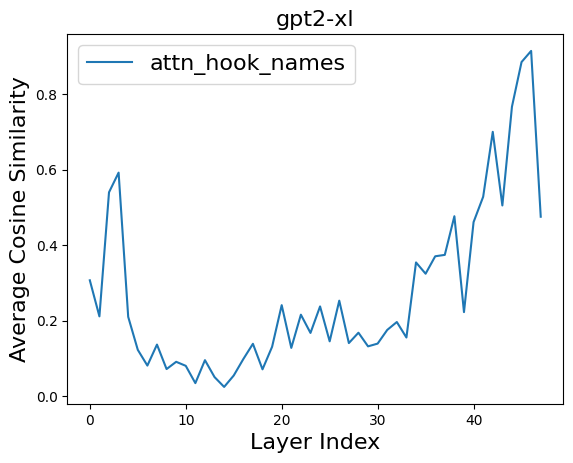

In [6]:
average_cosine_sim(
    ["Good day sir, how are you doing today?", "buggo", "I am doing well, thank you for asking.", "54 + 69 is "],
    ["attn_hook_names", "layer_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    4,
    False,
    True
)

In [6]:
activations = gather_activations_from_dataset(
    ["Good day sir, how are you doing today?"]*30,
    ["attn_hook_names"],
    model,
    tokenizer,
    MODEL_CONFIG,
    20,
    False,
    True
)


Gathering activations: 100%|██████████| 20/20 [00:01<00:00, 11.70it/s]


In [7]:
X = torch.concatenate([activations["attn_hook_names"][i][23] for i in range(20)])

In [8]:
X.shape

torch.Size([20, 1600])

In [9]:
X.norm(dim=1)

tensor([11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168,
        11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168, 11.0168,
        11.0168, 11.0168, 11.0168, 11.0168], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>)

In [10]:
normed_X = X / X.norm(dim=1)[:, None]

In [11]:
normed_X.shape

torch.Size([20, 1600])

In [13]:
sim = torch.mm(normed_X, normed_X.t())    

In [15]:
sim.shape

torch.Size([20, 20])

In [16]:
# Get the upper triangle (only want to compute each pair once)
sim_values = sim[torch.triu(torch.ones_like(sim), diagonal=1) == 1]

In [17]:
sim_values

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [19]:
model._name_

AttributeError: 'GPT2LMHeadModel' object has no attribute '_name_'